# FINAL VISUALIZATIONS FOR CS375

In [1]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange
import itertools

In [3]:
dbname = 'deep_retina'
collname = 'vgg_models'
exp_id = 'vgg16_retina'
port = 24444
conn = pm.MongoClient(port = port)
coll = conn[dbname][collname + '.files']
exp_ids = coll.distinct('exp_id')
print(exp_ids)

[u'vgg16', u'vgg16_retina', u'vgg16_validation', u'retina_vgg', u'vgg16_fc6_fc7_conv5_3', u'retina_vggval_fc678', u'retina_vggval_conv5', u'retina_vggval_conv3', u'retina_vggval_conv4', u'retina_vgg_val_conv5', u'retina_vgg_val_fc', u'retina_vgg_val_conv3', u'retina_vgg_val_conv4']


In [4]:
exp_id = exp_ids[3]
print(exp_id)

retina_vgg


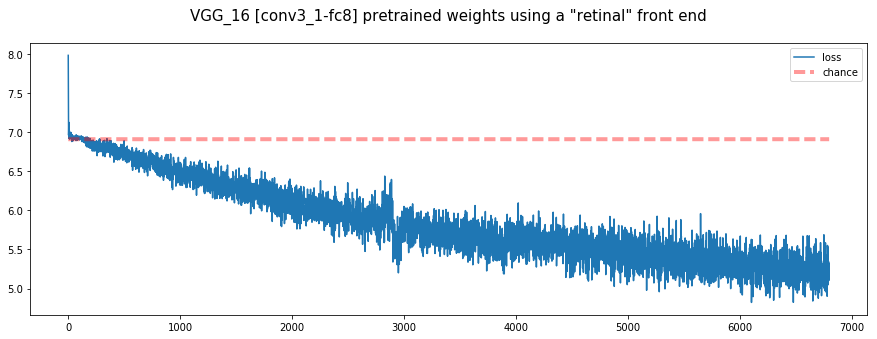

In [54]:
def get_losses(exp_id):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])


plt.figure(figsize=(15,5))
loss = get_losses(exp_id)
#smooth_loss = signal.convolve(loss, np.ones(100))
plt.plot(loss)
plt.plot(list(range(len(loss))), np.repeat(- np.log(.001), len(loss)), '--r', linewidth=4, alpha=.4)
plt.legend(['loss', 'chance'])
plt.title('VGG_16 [conv3_1-fc8] pretrained weights using a "retinal" front end\n', fontsize=15); 
# plt.xlabel()


# functions 

In [6]:
def get_neural_validation_data(exp_id):
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])

    results = [val_steps[i] for i in range(val_steps.count())]
    for res in results:
        res['step'] = coll.find({'_id': res['validates']})[0]['step']
    return results

In [7]:
def get_object_labels():
    """ 
    Get metadata
    """
    data_path = '/datasets/neural_data/neural_data.pkl'
    with open(data_path) as f:
        data = cPickle.load(f)
    meta = data['meta']
    labels = [np.unique(meta[meta['category'] == c]['obj']) \
                                   for c in np.unique(meta['category'])]

    labels = np.array(labels)
    labels = np.reshape(labels, (np.prod(labels.shape),))
    return labels

In [8]:
def plot_rdms(data, target_layers, labels, plot_size = [1,3], show_labels=0):
    for i, layer in enumerate(target_layers):
        rdm = data[layer]
        spearman_corrcoef = data['spearman_corrcoef_%s' % layer[4:]]
        ### YOUR CODE HERE
        plt.subplot(plot_size[0],plot_size[1] ,i+1)
        im = plt.imshow(1 - np.array(rdm), cmap='jet')
        plt.title('\n%s: spearman_corr_coeff = %g\n' %(layer, spearman_corrcoef))
        if show_labels: 
            plt.xticks(range(0,64,2), labels[0:64:2], rotation=90)
            if i == 0 or i == 3: plt.yticks(range(1,64,2), labels[1:64:2], fontsize=8)
        
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=.1)
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.set_yticklabels('')
        

In [9]:
def calculate_corr(l1, l2):
    l1 = np.reshape(l1, (np.prod(l1.shape),))
    l2 = np.reshape(l2, (np.prod(l2.shape),))
    correlation = np.corrcoef(l1, l2)
    return correlation[0,1]


In [10]:
def plot_regression_results(data, target_layers, step):
    for layer in target_layers:
        k = 'it_regression_%s' % layer[4:]
        regression_results = data[k]
        res = 1-regression_results['noise_corrected_multi_rsquared_loss']
        print('step', step, 'layer', layer, res)
        

In [11]:
def regression_results(data, target_layers, show=0):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    """
    res = np.zeros(len(target_layers))
    for i_layer in  range(0, len(target_layers)):
        k = 'it_regression_%s' % target_layers[i_layer][4:]
        regression_results = data[k]
        res[i_layer] = 1-regression_results['noise_corrected_multi_rsquared_loss']
        compile_regression_results['%s'%target_layers[i_layer]] = res[i_layer]

    if show:
        plt.scatter(range(0,len(res)), res)
        plt.xlim([-.5,len(res)+.05])
        plt.xticks([-1])
        for label, x, y in zip(target_layers, range(0,len(res)), res):
            plt.annotate(label+' layer\n  (%.04f)'%res[x], xy=(x, y), xytext=(-20, -25),
                textcoords='offset points', alpha=.9, fontsize=9)
        plt.title('noise corrected multi rsquared loss for each layer\n')
    
    return compile_regression_results

In [12]:
def extract_data(target): 
    for _id in exp_ids: 
        if target in _id: 
            exp_id = _id
    
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val, projection = ['validation_results'])
    validation_data = get_neural_validation_data(exp_id)
    idx = 0
    data = validation_data[idx]['validation_results']['valid0']
    highVar_data = validation_data[idx]['validation_results']['valid0']
    
    target_layers = []
    for key in data.keys(): 
        if 'rdm_' in key and 'rdm_it' not in key: 
            target_layers.append(key)
    target_layers = target_layers
    
    labels = get_object_labels()
    
    print 'layers in target: ', ; print target_layers
    
    return data, validation_data, target_layers, labels

In [13]:
def compare_rdms(layer): 
    
    plt.figure(figsize=(20, 20));
    labels = get_object_labels()

    # Plot RDM IT
    plt.subplot(121)
    im = plt.imshow((1-np.array(data['rdm_it'])), cmap='jet');
    plt.title('rdm_it\n');
    #plt.xticks(range(0,64,2), labels[0:64:2], rotation=90, fontsize=8);
    plt.yticks(range(1,64,2), labels[1:64:2], fontsize=8);
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=.1)
    plt.colorbar(im, cax=cax)

    # Plot RDM Pool 1
    plt.subplot(122);
    im = plt.imshow((1-np.array(data[layer])), cmap='jet');
    #plt.xticks(range(0,64,2), labels[0:64:2], rotation=90)
    plt.yticks(range(1,64,2), labels[1:64:2], fontsize=8)
    #plt.title(layer, '\n');
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=.1)
    plt.colorbar(im, cax=cax)
    ### END OF YOUR CODE

    correlation = calculate_corr(np.array(data['rdm_it']), np.array(data[layer]))
    print('Correlation between IT and %s: '%(layer), correlation)

In [18]:






# begin analysis







compile_regression_results = {}

## Neural analysis for conv3


In [19]:
data, validation_data, target_layers, labels = extract_data('vggval_conv3')

layers in target:  [u'rdm_pool3_3', u'rdm_conv3_1', u'rdm_conv3_3', u'rdm_conv3_2']


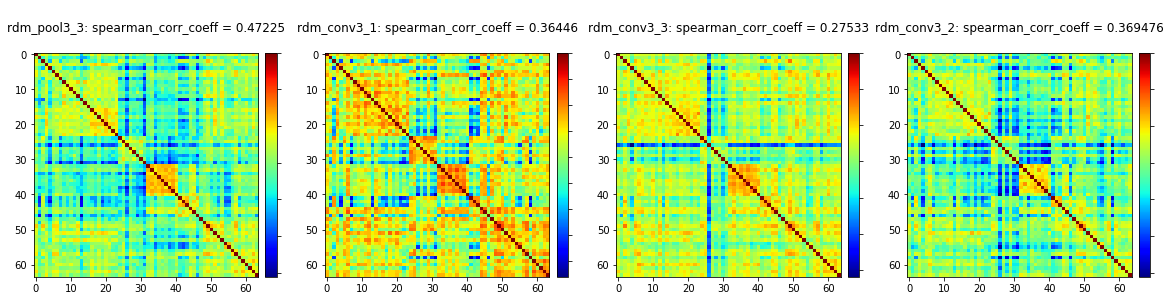

In [20]:
plt.figure(figsize=(20,13))
plot_rdms(data, target_layers, labels, [1,4])

(u'Correlation between IT and rdm_pool3_3: ', 0.52388162018088325)


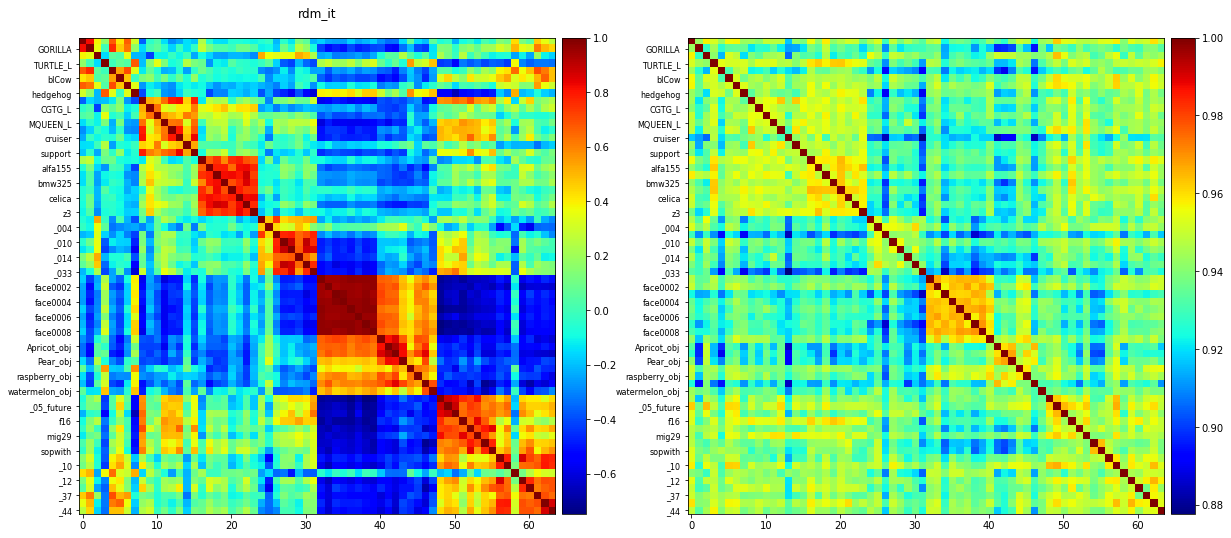

In [21]:
compare_rdms(target_layers[0])

### Analyzing the regression results

In [38]:
compile_regression_results = regression_results(data, target_layers, show=0); 

# results for conv4 

In [23]:
data, validation_data, target_layers, labels = extract_data('_val_conv4')

layers in target:  [u'rdm_pool4_3', u'rdm_conv4_2', u'rdm_conv4_3', u'rdm_conv4_1']


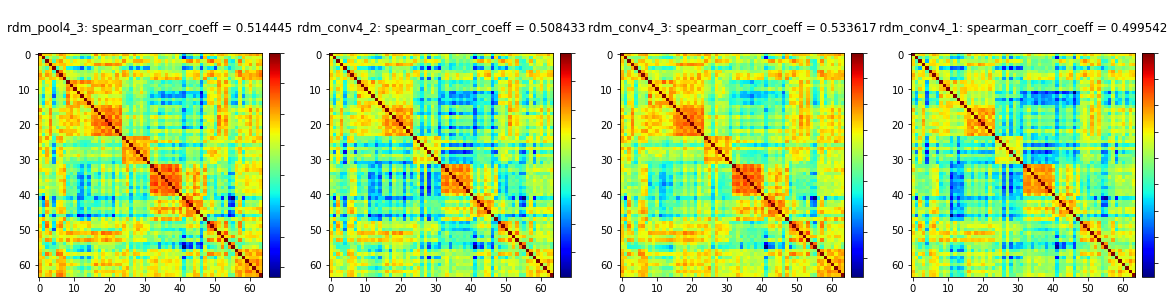

In [25]:
plt.figure(figsize=(20,13))
labels = get_object_labels()
plot_rdms(data, target_layers, labels, [1,4])

In [26]:
compile_regression_results = regression_results(data, target_layers, show=0); 

# results for conv5

In [27]:
data, validation_data, target_layers, labels = extract_data('_val_conv5')

layers in target:  [u'rdm_conv5_3', u'rdm_conv5_2', u'rdm_conv5_1']


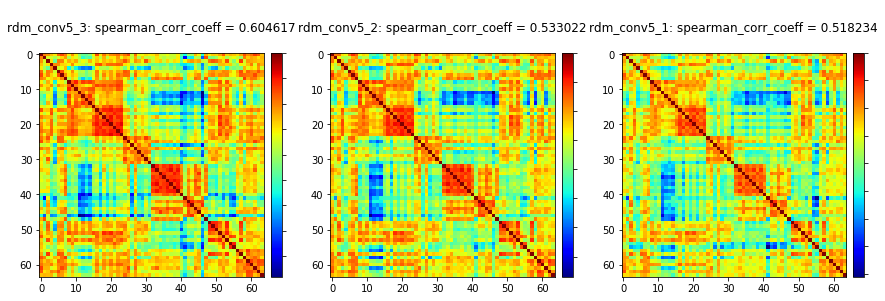

In [28]:
plt.figure(figsize=(20,13))
labels = get_object_labels()
plot_rdms(data, target_layers, labels, [1,4])

In [29]:
compile_regression_results = regression_results(data, target_layers, show=0); 

# results for fcs

In [30]:
data, validation_data, target_layers, labels = extract_data('_val_fc')

layers in target:  [u'rdm_fc6', u'rdm_fc7', u'rdm_fc8']


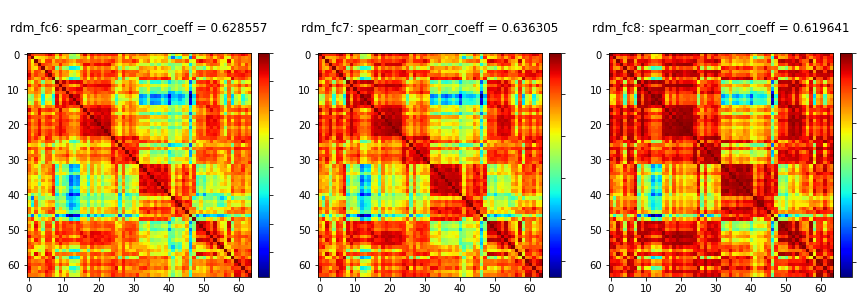

In [31]:
plt.figure(figsize=(20,13))
labels = get_object_labels()
plot_rdms(data, target_layers, labels, [1,4])

In [32]:
compile_regression_results = regression_results(data, target_layers, show=0); 

# all results compared to pretrained weights

In [33]:
# porting this over from instance-2
reference = {'conv5_1' : 0.36625050298004014,
             u'conv5_2': 0.38398729213059002,
             u'conv5_3': 0.37335877203271051,
             u'fc6'    : 0.45024695060320652,
             u'fc7'    : 0.37414172678281366,
             u'fc8'    : 0.33000450371964729}

In [34]:
layer_reg_it = compile_regression_results

In [35]:
ref_order = [0, 5, 2, 1,  3, 4]
ret_order = [3, 6, 5, 0, 9, 7, 8, 4,12, 11, 10, 1, 2, 13]

ret_names = [layer_reg_it.keys()[ii] for ii in ret_order]
ret_values = [layer_reg_it[layer_reg_it.keys()[ii]] for ii in ret_order]
ref_values = [reference[reference.keys()[ii]] for ii in ref_order]

In [36]:
ref_positions = range(len(ref_order)) + np.repeat(len(ret_order)-len(ref_order), len(ref_order))

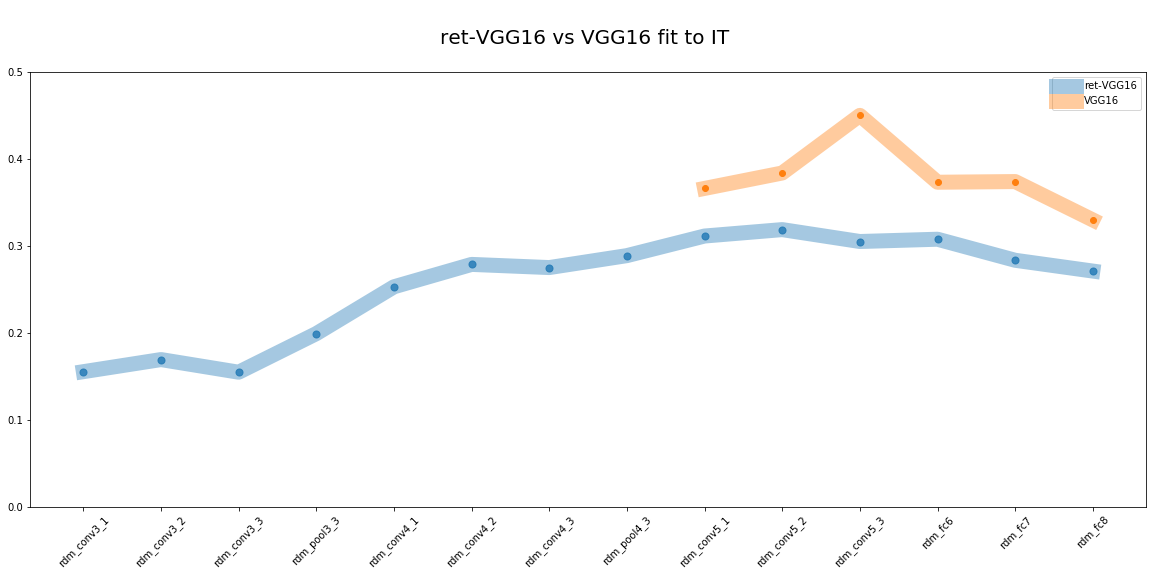

In [55]:
plt.figure(figsize=(20,8))
plt.plot(list(range(len(ret_values))), list(ret_values), linewidth=15, alpha=.4)
plt.plot(ref_positions, ref_values, linewidth=15, alpha=.4)
plt.xticks(range(len(ret_order)), ret_names, rotation=45)
plt.legend(['ret-VGG16', 'VGG16'])
plt.scatter(list(range(len(ret_values))), list(ret_values), s=50, alpha=.8)
plt.scatter(ref_positions, ref_values)
plt.ylim([0, .5]); 
plt.title('\nret-VGG16 vs VGG16 fit to IT \n', fontsize=20); 